# Activity recognition exercise

Aim of the exercise is to train a classifier (XGBoost) to recognize activities (lying, sitting, standing, walking, walking stairs up and down, jogging and cycling) from accelerometer data. The performance of the model will be evaluated using leave-one-subject-out cross validation. Also, the model will be tested with a separate test set.

Also, answer the questions.

Task 1 is graded from 0 to 50 points, task 2 from 0 to 25 points and task 3 fro 0 to 25 points.

If you have any problems (and Google doesn't help), don't hesitate to ask for help: kaalka@utu.fi

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib widget
#Import functions in other files
import load_data 
from get_features import get_activity_features
import signal_processing_functions
from measurement_data import MeasurementData

#Import commonly used python packages (some might be used only in the above functions)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#Import sklearn and scipy
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from scipy import signal, interpolate
from scipy.signal import butter, filtfilt

#Depending what packages you already have you may need to install these
#https://xgboost.readthedocs.io/en/stable/install.html
from xgboost import XGBClassifier
from glob import glob
from dataclasses import dataclass
import pathlib

Functions for filtering, preprocessing, resampling and segmenting the data. Some parts for all them are missing which you need to fill.

In [7]:
#Dictionary containing coding for each activity
label_dict = {'lying': 0,
              'sitting': 1,
              'standing': 2,
              'walking': 3,
              'jogging': 4,
              'stairsDown': 5,
              'stairsUp': 6,
              'cycling': 7,
              'test': 'test'}

def butter_filter(signal, cutoff, fs, order=4, btype='low'):
    """
    Performs Butterworth filtering on the given signal.
    """
    ###FILL THIS FUNCTION###

    b, a = butter(order, cutoff / (0.5 * fs), btype=btype)
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

def resample(signal, old_timestamps, new_timestamps, kind='linear'):
    """"
    Resample the signals with given timestamps
    """
    ###FILL THIS FUNCTION###

    interp_func = interpolate.interp1d(old_timestamps, signal, kind=kind, fill_value="extrapolate")
    resampled = interp_func(new_timestamps)

    return resampled

def preprocess_data(act, meas, data, new_fs, filter_cutoff):
    """Preprocesses the data by filtering (lowpass filter with 20 Hz cutoff frequency) and resampling it and cutting all the signals to same length.
       Returns the data as MeasurementData which is a dataclass object (can be found in measurement_data.py).
       Timestamps are in seconds."""
    data_resampled = []
    for channel in data.keys():
        channel_data = data[channel]
        timestamp = data[channel][:,0]
        ###FILL THIS PART###
        #Calculate sampling frequency (fs) from the timestamps and new timestamp for the resampling based on the current fs.

        # Estimate original sampling frequency
        fs = 1.0 / np.mean(np.diff(timestamp))
        # Create new timestamps for resampling over the same duration
        duration = timestamp[-1] - timestamp[0]
        num_samples = int(duration * new_fs)
        # Using endpoint=False to mimic continuous sampling
        new_time = np.linspace(timestamp[0], timestamp[-1], num=num_samples, endpoint=False)
        
        for i in range(1, 4):
            #Filter and resample each axis (from the array columns 1, 2 and 3)
            #Each axis is appended to data_resampled

            axis_signal = channel_data[:, i]
            # Filter the signal using a lowpass Butterworth filter
            filtered = butter_filter(axis_signal, filter_cutoff, fs)
            # Resample the filtered signal to the new timestamps
            resampled = resample(filtered, timestamp, new_time)
            
            data_resampled.append(resampled)
            
    min_length = min(len(data_resampled[0]), len(data_resampled[1]), len(data_resampled[2]), len(data_resampled[3]), len(data_resampled[4]), len(data_resampled[5]))
    for i, d in enumerate(data_resampled):
        data_resampled[i] = d[0:min_length]

    #new timestamp for the resampled data
    ts = np.linspace(0, len(data_resampled[0])/new_fs, len(data_resampled[0]))

    data = MeasurementData(meas + ': ' + act, ts, data_resampled[0], data_resampled[1], data_resampled[2], data_resampled[3], data_resampled[4], data_resampled[5], label_dict[act]) 


    return data

def segment_measurement(arr, segment_length, id, label):
    """Segments the signals to given length, calculates total acceleration for each segment (shape of each segment should be (8, 50)). 
       Also returns label and subject id for each segment. Make sure the shapes are correct (label and subject if for every segment)."""
    segments, label_segs, subject_segs = [], [], []
    ###FILL THIS PART###
    #Segment the data to given length, calculate total acceleration for each sensor (square root of sums of squared axis)
    #Stack all the axis and total accelerations so you get shape 8,50
    #Add the subject id and label to the subject_segs and label_segs list, respectively (for every segment).
    
    total_samples = arr.shape[1]
    n_segments = total_samples // segment_length
    
    for seg in range(n_segments):
        start = seg * segment_length
        end = start + segment_length
        
        # Extract segments for sensor 1 (rows 0-2) and sensor 2 (rows 3-5)
        seg_sensor1 = arr[0:3, start:end]
        seg_sensor2 = arr[3:6, start:end]
        
        # Calculate total acceleration for each sensor for the segment
        total_accel1 = np.sqrt(np.sum(seg_sensor1**2, axis=0))
        total_accel2 = np.sqrt(np.sum(seg_sensor2**2, axis=0))
        
        # Stack the data to form an (8, segment_length) segment:
        # Order: sensor1_x, sensor1_y, sensor1_z, sensor1_total, sensor2_x, sensor2_y, sensor2_z, sensor2_total
        segment = np.vstack([seg_sensor1,
                             total_accel1[np.newaxis, :],
                             seg_sensor2,
                             total_accel2[np.newaxis, :]])
        
        segments.append(segment)
        label_segs.append(label)
        subject_segs.append(id)
    
    return segments, label_segs, subject_segs


# Task 1: Preprocessing (0-50 p)

The data is first loaded and then preprocessed and segmented. Then the features are calculated for each segment.

In [10]:

#Loading of the data from data, test_data and test_labels folder. The data is saved to dictionaries measurement and test_measurement. 
#The dictionaries have the following sturcture: ids: measurement numbers: activities: wrist/thigh. 
#Wrist and thigh are arrays containing timestamp and x, y and z axis for each sensors (wirst and thigh, respectively).
folder = pathlib.Path(pathlib.Path.cwd(), 'data')
test_folder = pathlib.Path(pathlib.Path.cwd(), 'test_data')
test_labels_folder = pathlib.Path(pathlib.Path.cwd(), 'test_labels')
measurements = load_data.load_data(folder)
test_measurements = load_data.load_data(test_folder)

#New sampling frequency
fs = 50

#Empty lists to save the signals, labels for each signal and subjects for the cross validation and the same for test data.
signals, signal_labels, subjects = [], [], []
test_signals, test_signal_labels, test_subjects = [], [], []
segment_length = 50

#The measurements are preprocessed and segmented         
for id in measurements.keys():
    for meas in measurements[id].keys():
        for act in measurements[id][meas].keys():
                measurement = preprocess_data(act, meas, measurements[id][meas][act], fs, 20)
                arr = np.array([measurement.acc_x_thigh, measurement.acc_y_thigh, measurement.acc_z_thigh, measurement.acc_x_wrist, measurement.acc_y_wrist, measurement.acc_z_wrist])
                segments, label_segments, subject_segments = segment_measurement(arr, segment_length, id, measurement.label)                
                signals.append(segments)
                signal_labels.append(label_segments)
                subjects.append(subject_segments)

for id in test_measurements.keys():
    for meas in test_measurements[id].keys():
        for act in test_measurements[id][meas].keys():
                measurement = preprocess_data(act, meas, test_measurements[id][meas][act], fs, 20)
                arr = np.array([measurement.acc_x_thigh, measurement.acc_y_thigh, measurement.acc_z_thigh, measurement.acc_x_wrist, measurement.acc_y_wrist, measurement.acc_z_wrist])
                segments, _, subject_segments = segment_measurement(arr, segment_length, id, measurement.label)   
                label_segments = np.array(pd.read_csv(str(test_labels_folder) + '/' + id + '.csv'))
                segments = segments[0:len(label_segments)]
                label_segments = label_segments[0:len(segments)]           
                test_signals.append(segments)
                test_subjects.append(subject_segments)
                test_signal_labels.append(label_segments)

#The features are calculated for each segment and saved to x_train, y_train, x_test_set and y_test_set
x_train = []
y_train = []
X_test_set = []
y_test_set = []
for sig, sig_l in zip(signals, signal_labels):
    for segment, label in zip(sig, sig_l):
        x_train.append(get_activity_features(segment, len(segment[0]), fs))
        y_train.append(label)

for sig, sig_l in zip(test_signals, test_signal_labels):
     for segment, label in zip(sig, sig_l):
          X_test_set.append(get_activity_features(segment, len(segment[0]), fs))
          y_test_set.append(label)

X = np.array(x_train)
y = np.array(y_train)
x_test_set = np.array(X_test_set)
y_test_set = np.array(y_test_set)
subjects = np.concatenate(subjects)


C:\Users\matil\OneDrive\Desktop\yliopisto\opiskelu\kurssit\dippa\kevät 2025\analytics for health wearables\exercise5\exercise5\load_data.py:23: DtypeWarning: Columns (11,12,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(glob((file))[0], delimiter=';', skiprows=2)
C:\Users\matil\OneDrive\Desktop\yliopisto\opiskelu\kurssit\dippa\kevät 2025\analytics for health wearables\exercise5\exercise5\signal_processing_functions.py:12: RuntimeWarning: invalid value encountered in divide
  s_norm = min_val + (signal_ - np.nanmin(signal_)) * (max_val - min_val) / \


# Task 2: Leave-one-subject-out cross validation (0-25 p)

Leave-one-subject-out cross validation is done by spliting the data so that one subject is left for testing and others are used for training. This is done for all the subjects.
You can use LeaveOneGroupOut for splitting from sklearn. You need a for loop to loop through all the splits.

Q: What is the benefit of using leave-one-subject-out cross validation?

Leave-one-subject-out cross validation ensures that the model is tested on entirely unseen subjects, which helps evaluate its ability to generalize across different individuals. This is particularly important when there is significant variability between subjects, as it prevents the model from overfitting to subject-specific features and provides a more realistic assessment of its performance in real-world applications.

Use XGBoost as a classifier.

Average accuracy: 83.14%


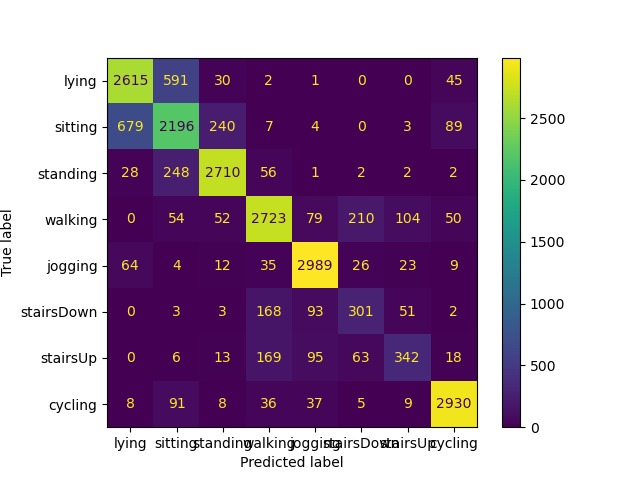

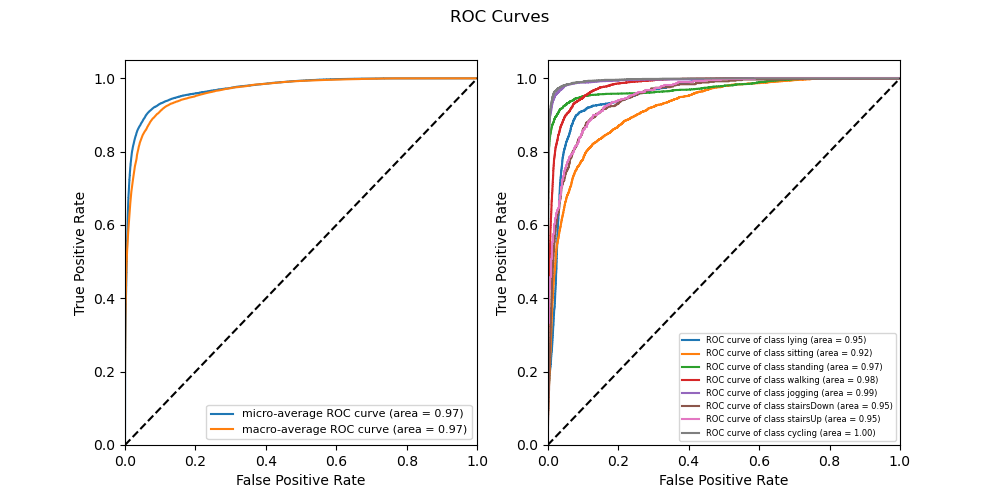

In [13]:
#Sum of all the accuracies
accuracy_sum = 0
logo = LeaveOneGroupOut()
#List to save all the probabilities
y_prob_all = []
#List to save all the true labels
y_test_all = []
#List to save all the predictions.
y_pred_all = []

###FILL HERE THE LEAVE-ONE-SUBJECT-OUT CV###
#Inputs: X, y from task 1, outputs: y_prob_all, y_test_all, y_pred_all
#Save the probabilities, true labels and predictions to the above lists for calculation of roc curves and confusion matrix. Also calculate the sum of the accuracies for average accuracy.

# Loop through each leave-one-subject-out split
for train_index, test_index in logo.split(X, y, groups=subjects):
    # Split data: train on all subjects except one, test on the left-out subject
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize and train the classifier
    clf = XGBClassifier(eval_metric='logloss', random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict probabilities and class labels on the test set
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    
    # Compute and accumulate accuracy for this fold
    acc = accuracy_score(y_test, y_pred)
    accuracy_sum += acc
    
    # Append the results from this split
    y_prob_all.append(y_prob)
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)

#Results of the whole leave-one-subject-out cross validation: Accuracy, roc curves and confusion matrix

print('Average accuracy: %.2f%%' % ((accuracy_sum/(8))*100))

enc = OneHotEncoder()
y_test_all_enc = enc.fit_transform(np.concatenate(y_test_all).reshape(-1,1)).toarray()

signal_processing_functions.roc_curves(y_test_all_enc, np.concatenate(y_prob_all), ['lying', 'sitting', 'standing', 'walking', 'jogging', 'stairsDown', 'stairsUp', 'cycling'])
cm = confusion_matrix(np.concatenate(y_test_all), np.concatenate(y_pred_all))
disp = ConfusionMatrixDisplay(cm, display_labels=['lying', 'sitting', 'standing', 'walking', 'jogging', 'stairsDown', 'stairsUp', 'cycling'])
disp.plot()
plt.show()

# Task 3: Testing (0-25 p)

The model should be trained again with the whole training data and then tested with the test data. Note that the test subjects are now included in the training data which might improve the results.

Q: Compare the accuracy of the cross validation and the test set. How the difference can be explained? What can you tell about the results?

The cross-validation accuracy was 83.14%, while the test set accuracy was 77.99%. This drop in accuracy can be explained by a few factors:

In cross-validation, the model gets to see data from all subjects at some point, making it more familiar with the dataset. However, the test set includes entirely new subjects, whose movement patterns may differ, making it harder for the model to predict correctly. The model might also pick up subject-specific traits during cross-validation, leading to slightly optimistic results. When tested on completely unseen subjects, it may not perform as well. Additionally, differences in sensor placement, signal quality, or recording conditions in the test set could affect accuracy.

Overall, while 83% accuracy in cross-validation shows the model has learned useful patterns, the drop to 78% suggests it still struggles with generalizing to new subjects. This is common in wearable sensor data, where individuals move differently.

Test accuracy: 77.99%


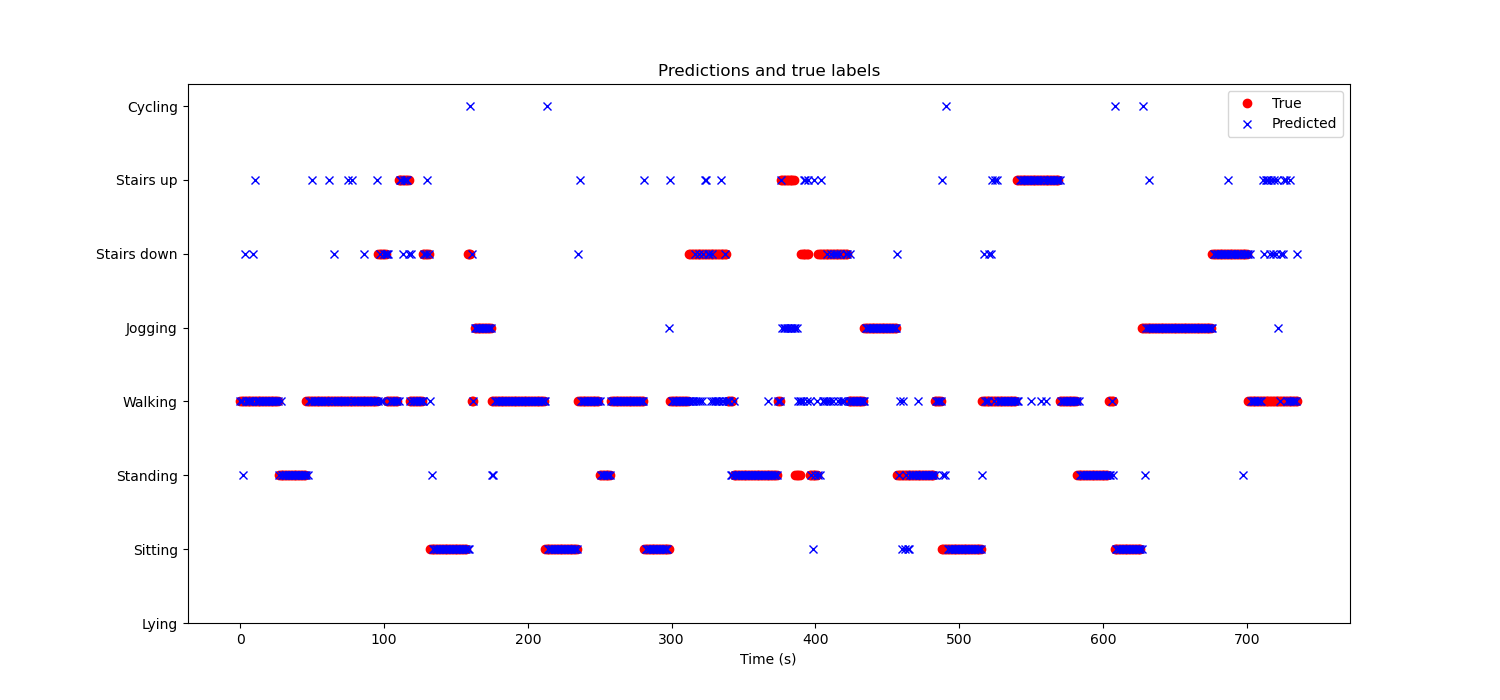

C:\Users\matil\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\matil\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


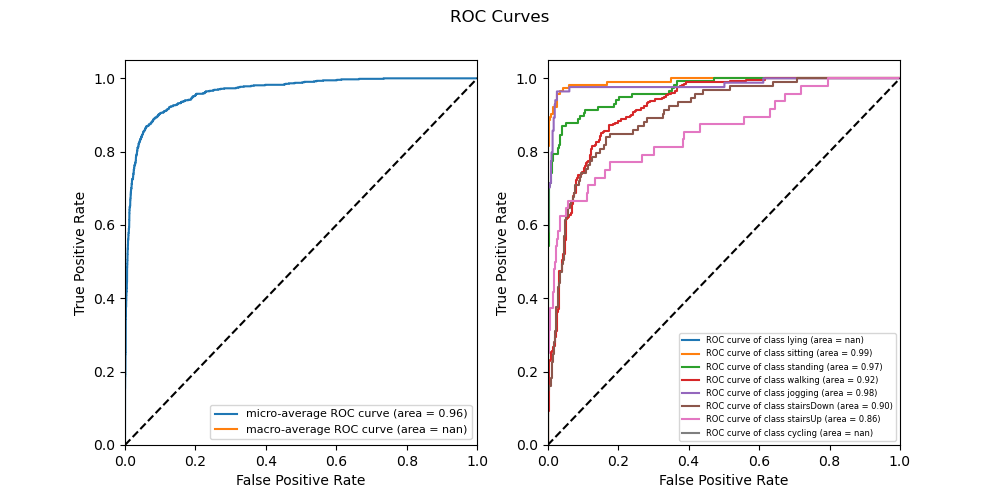

In [16]:

###FILL THE TRAINING AND TESTING WITH THE TEST DATA (x_test_set and y_test_set)
# make predictions for test data
#Variable names to use: y_pred (predictions), y_prob (probabilities)

# Train the classifier using all training data
clf = XGBClassifier(eval_metric='logloss', random_state=42)
clf.fit(X, y)

# Make predictions on the test data
y_pred = clf.predict(x_test_set)
y_prob = clf.predict_proba(x_test_set)


# evaluate predictions
accuracy = accuracy_score(y_test_set.astype(int), y_pred)
print('Test accuracy: %.2f%%' % (accuracy*100))
y_test_enc = enc.transform(y_test_set.reshape(-1,1)).toarray()


fig = plt.figure(figsize=(15,7))
plt.plot(y_test_set, 'ro')
plt.plot(y_pred, 'bx')
plt.title('Predictions and true labels')
plt.legend(['True', 'Predicted'])
plt.xlabel('Time (s)')
plt.yticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7], labels=['Lying', 'Sitting', 'Standing', 'Walking', 'Jogging', 'Stairs down', 'Stairs up', 'Cycling'])
plt.show()

signal_processing_functions.roc_curves(y_test_enc, y_prob, ['lying', 'sitting', 'standing', 'walking', 'jogging', 'stairsDown', 'stairsUp', 'cycling'])
cm = confusion_matrix(y_test_set, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['lying', 'sitting', 'standing', 'walking', 'jogging', 'stairsDown', 'stairsUp', 'cycling'])
